In [1]:
import numpy as np

In [2]:
data = np.load('small_data.npz')
X = data['X']
y = data['y'].reshape(-1, 1)

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

In [4]:
np.unique(y)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

In [5]:
from sklearn.preprocessing import OneHotEncoder
onehot = OneHotEncoder(sparse=False)
y_train = onehot.fit_transform(y_train)

In [6]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, AvgPool2D, Dropout

#LeNet-5 arch
model = Sequential()
model.add(Conv2D(6, kernel_size=(5, 5), activation='relu', padding='valid', input_shape = X_train.shape[1:]))
model.add(AvgPool2D(pool_size=(2,2)))
model.add(Conv2D(16, kernel_size=(5,5), activation='relu', padding='valid'))
model.add(AvgPool2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(y_train.shape[1], activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 6)         156       
_________________________________________________________________
average_pooling2d (AveragePo (None, 13, 13, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 9, 16)          2416      
_________________________________________________________________
average_pooling2d_1 (Average (None, 4, 4, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8

In [7]:
history = model.fit(X_train, y_train, validation_split=.1, batch_size=8, epochs=25, shuffle=True)

Epoch 1/25
825/825 [==============================] - 3s 4ms/step - loss: 1.0608 - accuracy: 0.7060 - val_loss: 0.5541 - val_accuracy: 0.8433
Epoch 2/25
825/825 [==============================] - 3s 4ms/step - loss: 0.4035 - accuracy: 0.8860 - val_loss: 0.4103 - val_accuracy: 0.8828
Epoch 3/25
825/825 [==============================] - 3s 4ms/step - loss: 0.2851 - accuracy: 0.9144 - val_loss: 0.3636 - val_accuracy: 0.9033
Epoch 4/25
825/825 [==============================] - 3s 4ms/step - loss: 0.2344 - accuracy: 0.9282 - val_loss: 0.3044 - val_accuracy: 0.9251
Epoch 5/25
825/825 [==============================] - 3s 4ms/step - loss: 0.1846 - accuracy: 0.9464 - val_loss: 0.2936 - val_accuracy: 0.9251
Epoch 6/25
825/825 [==============================] - 3s 4ms/step - loss: 0.1685 - accuracy: 0.9518 - val_loss: 0.3774 - val_accuracy: 0.9196
Epoch 7/25
825/825 [==============================] - 3s 4ms/step - loss: 0.1348 - accuracy: 0.9562 - val_loss: 0.3609 - val_accuracy: 0.8992
Epoch 

In [8]:
model.save('models/lenet_25epochs_small_extended.h5')

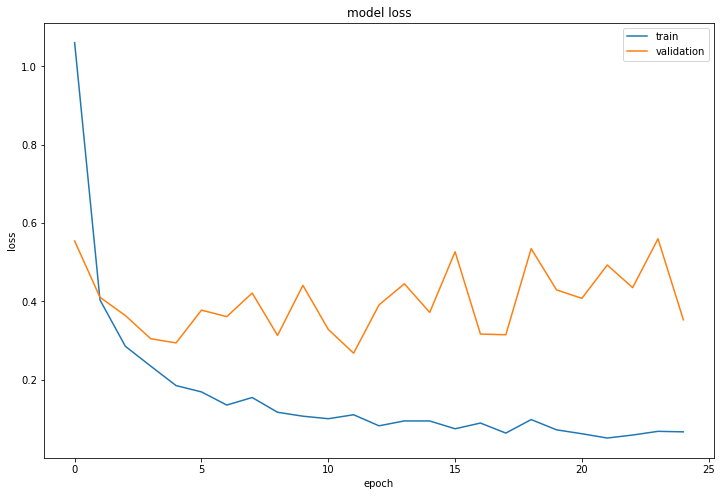

In [9]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(12, 8))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

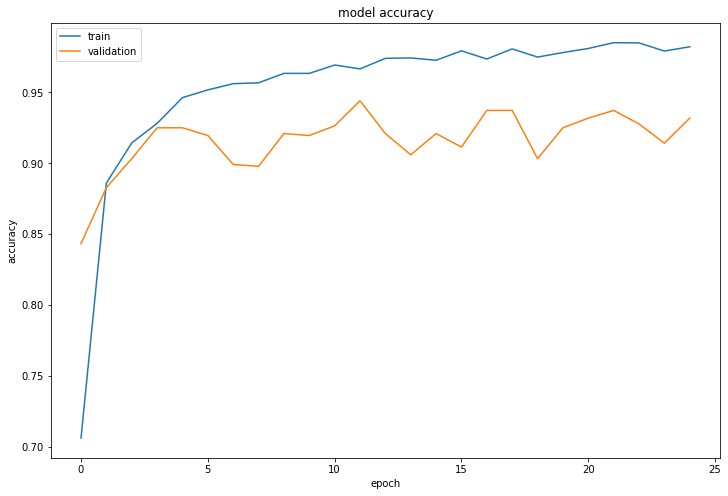

In [10]:
f, ax = plt.subplots(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [11]:
preds = np.argmax(model.predict(X_test), axis=1)

Accuracy: 0.930752453653217


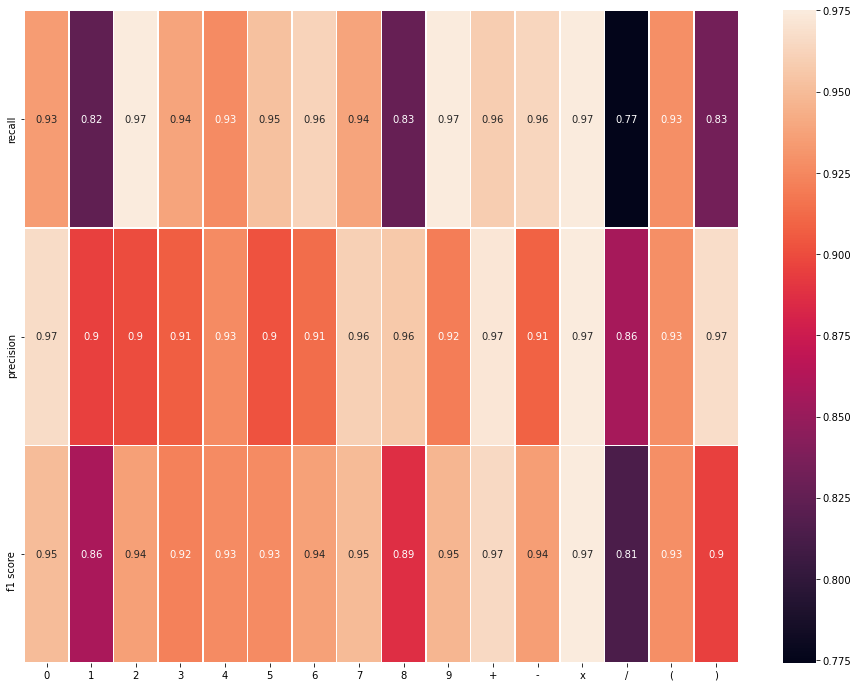

In [12]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import seaborn as sn
f, ax = plt.subplots(figsize=(16, 12))
print('Accuracy: {}'.format(accuracy_score(y_test, preds)))
recall = recall_score(y_test, preds, average=None)
precision = precision_score(y_test, preds, average=None)
f1 = f1_score(y_test, preds, average=None)
ax = sn.heatmap([recall, precision, f1], xticklabels=[str(i) for i in range(10)] + ['+', '-', 'x', '/', '(', ')'], yticklabels=['recall', 'precision', 'f1 score'], annot=True, linewidths=.5)

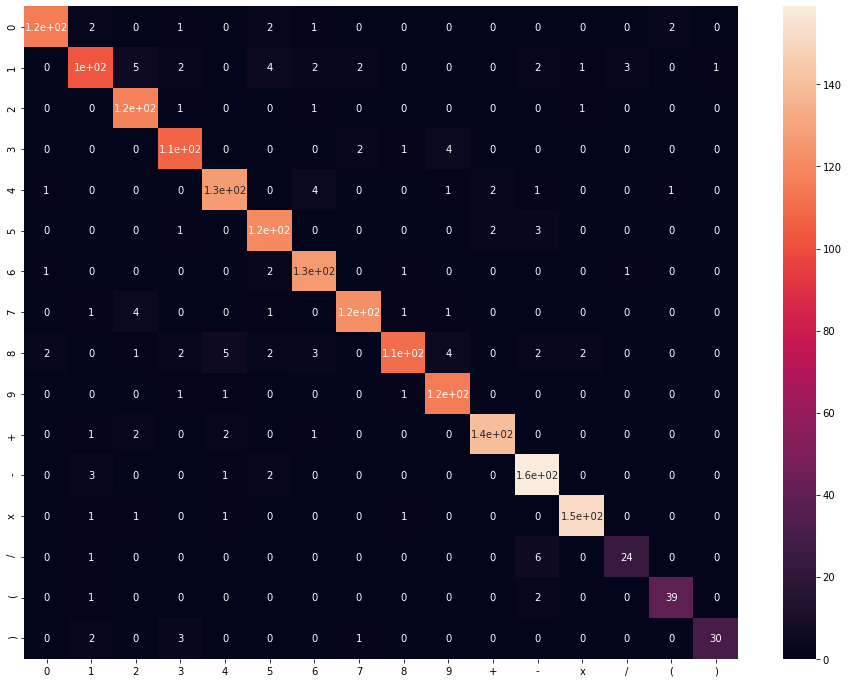

In [13]:
from sklearn.metrics import confusion_matrix
f, ax = plt.subplots(figsize=(16, 12))
cm = confusion_matrix(y_test, preds)
ax = sn.heatmap(cm, annot=True, xticklabels=[str(i) for i in range(10)] + ['+', '-', 'x', '/', '(', ')'], yticklabels=[str(i) for i in range(10)] + ['+', '-', 'x', '/', '(', ')'])

## Create a small dataset using images that big model is sure of

In [21]:
from keras.models import load_model
with open('filepaths.txt', 'r') as inp:
    filepath = inp.read().split('\n')
model = load_model('models/lenet_25epochs.h5')
all_probs = model.predict(X)
all_preds = np.argmax(all_probs, axis=1)

In [22]:
import os
import shutil

probs_dict = {
    c:0 for c in np.unique(y)
}

for i, label in enumerate(y):
    if all_preds[i] == label[0] and all_probs[i][label[0]] == 1.:
        if probs_dict[label[0]] > 2000:
            continue
        try:
            shutil.copy(filepath[i], os.path.join('small_dataset', *filepath[i].split('/')[1:]))
            probs_dict[label[0]] += 1
        except:
            os.mkdir(os.path.join('small_dataset', *filepath[i].split('/')[1:-1]))
            shutil.copy(filepath[i], os.path.join('small_dataset', *filepath[i].split('/')[1:]))
            probs_dict[label[0]] += 1
print(probs_dict)
# Manually copy all images of forward slash

{0: 60, 1: 57, 2: 52, 3: 57, 4: 54, 5: 35, 6: 44, 7: 40, 8: 54, 9: 51, 10: 58, 11: 16, 12: 60, 13: 0, 14: 25, 15: 9}
